In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
folder = 'training_20180910/'


In [2]:
txts = [file for file in os.listdir(folder) if '.txt' in file]
anns = [file for file in os.listdir(folder) if '.ann' in file]
ids = [file.strip('.txt') for file in txts]

In [3]:
def load_txt(txt=None, i=None):
    '''
    Pass text file name or index to load file
    '''
    if txt is not None:
        with open(folder + txt) as f:
            lines = f.readlines()
        return lines
    elif i is not None:
        with open(folder + txts[i]) as f:
            lines = f.readlines()
        return lines
    
def load_txt(txt=None, i=None):
    '''
    Pass text file name or index to load file
    '''
    if txt is not None:
        with open(folder + txt) as f:
            lines = f.readlines()
        return lines
    elif i is not None:
        with open(folder + txts[i]) as f:
            lines = f.readlines()
        return lines


'''
Get chief complaint and history from medical record
Save to patient_record_summary.pickle
'''
patient_text_rows = []
            
for patient_id in ids:
    patient_text = {}
    
    txt = patient_id + '.txt'
    lines = load_txt(txt)
    
    # get chief complaint
    chief_complaint = ''
    chief_complaint_idx = -1
    chief_complaint_end_idx = -1
    
    # start and end of chief complaint
    for i, line in enumerate(lines):
        if 'chief complaint' in line.lower():
            chief_complaint_idx = i
            break
    for j, line in enumerate(lines[i:]):
        if line == '\n':
            chief_complaint_end_idx = j + i
            break
    
    # trim \n and join
    if chief_complaint_idx > -1:
        chief_complaint = lines[chief_complaint_idx:chief_complaint_end_idx]
        chief_complaint = [line.strip('\n') for line in chief_complaint]
        chief_complaint = ' '.join(chief_complaint)
        
    patient_text['chief_complaint'] = chief_complaint

    
    # get present history
    present_history = ''
    present_history_idx = -1
    present_history_end_idx = -1
    
    for i, line in enumerate(lines):
        if 'history of present illness' in line.lower():
            present_history_idx = i
            break
    for j, line in enumerate(lines[i+3:]):
        #find the next header
        if ':' in line:
            present_history_end_idx = j + i + 3
            break
    
    if present_history_idx > -1:
        present_history = lines[present_history_idx:present_history_end_idx]
        present_history = [line.strip('\n') for line in present_history]
        present_history = ' '.join(present_history)
    
    patient_text['present_history'] = present_history
    
    
    patient_text_rows.append(patient_text)
    
patient_df = pd.DataFrame(patient_text_rows, index=ids)
patient_df.to_csv('patient_record_summary.csv')

In [5]:

texts = list(patient_df['chief_complaint'] + ' ' + patient_df['present_history'])

In [139]:
texts[8]

"Chief Complaint: Left Foot Infection, DKA History of Present Illness: Mr. [**Known lastname 14611**] is a 49 year old male with a history of type II diabetes, charcot's foot s/p multiple surgeries, and previous MRSA infection who presented to his podiatrist on [**2149-2-21**] with two days of nausea, vomiting (clear, non-bilious, non bloody) , productive cough (sputum color not noted), fatigue, and pain and redness of his left foot.  He was found to have a draining wound (approximately 1 cm in width x 1 cm in depth) on his left lower leg, just superior to the lateral malleolus with an area of surrounding cellulitis. He was transferred to the Emergency Department for treatment with IV antibiotics, and observation. Of note is that the patient missed his last four doses of lantus insulin, due to running out of medication. ."

In [5]:
file =  open('chief_history.txt', 'w')
for line in texts:
    file.write(line + '\n')
file.close()

In [6]:
from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = tokenizer.train_new_from_iterator(all_reason_drug_pairs, vocab_size=2446)

tokenizer = AutoTokenizer.from_pretrained('ann/tokenizer')
tokenizer.add_special_tokens({'additional_special_tokens': 
                             ['<pair>', '<drug>', '<reas>', '<sep>']})


from transformers import BertConfig
from transformers import BertForMaskedLM

config = BertConfig(
    vocab_size=len(tokenizer.vocab),
    max_position_embeddings=514,
    num_attention_heads=4,
    num_hidden_layers=2,
)
model = BertForMaskedLM(config=config)

In [6]:
# Update new tokens from text into bert model

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
import torch

vocab_finder = Tokenizer(WordLevel(unk_token='<unk>'))
trainer = WordLevelTrainer()
vocab_finder.pre_tokenizer = Whitespace()
vocab_finder.train_from_iterator(texts)

tokens = [key for key, value in vocab_finder.get_vocab().items()]

from transformers import AutoModelForMaskedLM, AutoTokenizer

model_name = 'prajjwal1/bert-tiny'

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
num_added_toks = tokenizer.add_tokens(tokens)


model = AutoModelForMaskedLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(34282, 128)

In [9]:
tokenizer.save_pretrained('text_tokenizer')
model.save_pretrained('text_model')

In [10]:
from transformers import AutoModelForMaskedLM
model_name = 'prajjwal1/bert-mini'
model = AutoModelForMaskedLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NameError: name 'tokenizer' is not defined

In [10]:
from transformers import LineByLineTextDataset

dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="chief_history.txt",
    block_size=512
)

from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./text_model",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_gpu_train_batch_size=8,
    save_steps=50,
    save_total_limit=2,
    prediction_loss_only=True,
    report_to=None
)

trainer = Trainer(
    model=model,
    args=training_args,
    # data_collator=mlm_collator,
    # train_dataset=train_dataset,
    data_collator=data_collator,
    train_dataset=dataset,
)

trainer.train()
trainer.save_model('text_model')

In [19]:
from transformers import pipeline

fill_mask = pipeline(
    'fill-mask',
    model='text_model',
    tokenizer='text_tokenizer'
)
text = ' History of Present Illness: Mr. [**Known lastname 3234**] is a 36 year old gentleman with a PMH signifciant with dilated cardiomyopathy s/p AICD, asthma, and HTN admitted to an OSH with dyspnea now admitted to the MICU after PEA arrest x2. The patient initially presented to LGH ED with hypoxemic respiratory distress. While at the OSH, he received CTX, azithromycin, SC epinephrine, and solumedrol. While at the OSH, he became confused and subsequently had an episode of PEA arrest and was intubated. He received epinephrine, atropine, magnesium, and bicarb. In addition, he had bilateral needle thoracostomies with report of air return on the left, and he subsequently had bilateral chest tubes placed.  After approximately 15-20 minutes of rescucitation, he had ROSC. He received vecuronium and was started on an epi gtt for asthma and a cooling protocol, and was then transferred to [**Hospital1 18**] for further evaluation. Of note, the patient was admitted to LGH in [**1-4**] for dyspnea, and was subsequently diagnosed with a CAP and [MASK] treated with CTX and azithromycin. Per his family, he has also had multiple admissions this winter for asthma exacerbations.'
fill_mask(text)

loading configuration file text_model\config.json
Model config BertConfig {
  "_name_or_path": "text_model",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 34282
}

loading configuration file text_model\config.json
Model config BertConfig {
  "_name_or_path": "text_model",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "i

In [26]:
from transformers import AutoModel

In [27]:
model2 = AutoModel.from_pretrained('text_model')

loading configuration file text_model\config.json
Model config BertConfig {
  "_name_or_path": "text_model",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 34282
}

loading weights file text_model\pytorch_model.bin
Some weights of the model checkpoint at text_model were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transf

In [34]:
from transformers import AutoModel
device = torch.device('cpu')
model = AutoModel.from_pretrained('text_model')
def padding_collator(dataset, padding=128):
    inps = []
    for data in dataset:
        padded = torch.zeros(padding)
        inp = data['input_ids']
        inp = torch.tensor(inp)
        
        if len(inp) > len(padded):
            padded[:padding] = inp[:padding]
        else:
            padded[:len(inp)] = inp[:]
        inps.append(padded)
    inps = torch.vstack(inps).to(device).to(torch.int64)
    return inps



loading configuration file text_model\config.json
Model config BertConfig {
  "_name_or_path": "text_model",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 34282
}

loading weights file text_model\pytorch_model.bin
Some weights of the model checkpoint at text_model were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transf

In [62]:
inps = padding_collator(dataset[:])
model.eval()
outs = model.forward(inps)['last_hidden_state'].detach()

pickle.dump(outs, open('text_encodings', 'wb'))

C:\Users\Andy\miniconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


# Look for kmeans on encodings

In [91]:
from sklearn import feature_extraction
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Perform Tf-Idf on present-history documents
# vectorizer = feature_extraction.text.TfidfVectorizer()
# corpus = list(patient_df['present_history'])
# vectors = vectorizer.fit_transform(corpus2)
outs_flat = outs.view(285, -1)
mat = cosine_similarity(outs_flat, outs_flat)

modelkmeans = KMeans(9)
cluster_x = modelkmeans.fit_predict(outs_flat)

from sklearn.decomposition import PCA
pca = PCA(2)
pca_x = pca.fit_transform(outs_flat)

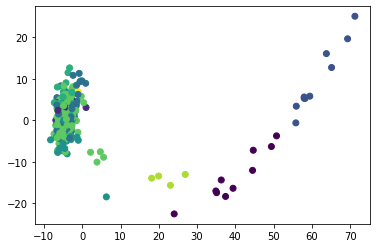

In [92]:
plt.scatter(pca_x.T[0], pca_x.T[1], c=cluster_x)

In [81]:
pca.explained_variance_ratio_

array([0.09200217, 0.01387377])

In [84]:
interesting = pca_x.T[0] > 10


In [88]:
dataset[interesting]

TypeError: only integer scalar arrays can be converted to a scalar index

# TFIDF on ann

In [129]:
file = 'ann_train.txt'
with open(file) as f:
    lines = f.readlines()
    

from sklearn import feature_extraction
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Perform Tf-Idf on present-history documents
vectorizer = feature_extraction.text.TfidfVectorizer()
# corpus = list(patient_df['present_history'])
text_vectors = vectorizer.fit_transform(lines)

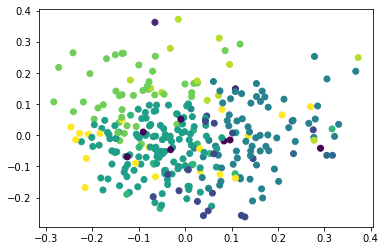

In [130]:
kmeans = KMeans(10)
cluster_text = kmeans.fit_predict(vectors)

from sklearn.decomposition import PCA
pca = PCA(2)
pca_text = pca.fit_transform(vectors.todense())

plt.scatter(pca_text.T[0], pca_text.T[1], c=cluster_text)

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:18<00:00,  2.14it/s]


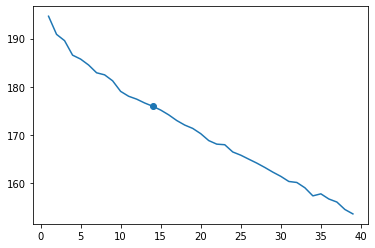

In [106]:
# modelkmeans = KMeans(3)
# modelkmeans.fit_transform(vectors)

# Attempt to find ideal number of clusters
sum_of_squared_dists = []
K = range(1, 40)
for k in tqdm(K):
    km = KMeans(n_clusters=k)
    km = km.fit(vectors)
    sum_of_squared_dists.append(km.inertia_)
# K = modelkmeans

plt.plot(K[:len(sum_of_squared_dists)], sum_of_squared_dists)
plt.scatter(K[13], sum_of_squared_dists[13])

In [103]:
plt.plot(K[:len(sum_of_squared_dists)], sum_of_squared_dists)
plt.scatter(K[13], sum_of_squared_dists[13])

TypeError: 'KMeans' object is not subscriptable

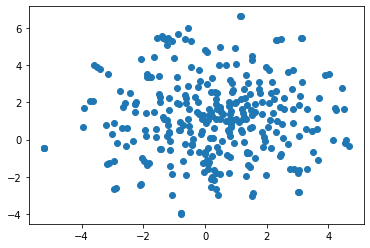

In [115]:
from sklearn.manifold import TSNE

tsne = TSNE(2, perplexity=50)
tsne_x = tsne.fit_transform(vectors.todense())

plt.scatter(tsne_x.T[0], tsne_x.T[1])

In [121]:
vectors.todense().shape

(303, 3321)

In [125]:
cluster2_x = KMeans(10).fit_predict(tsne_x)

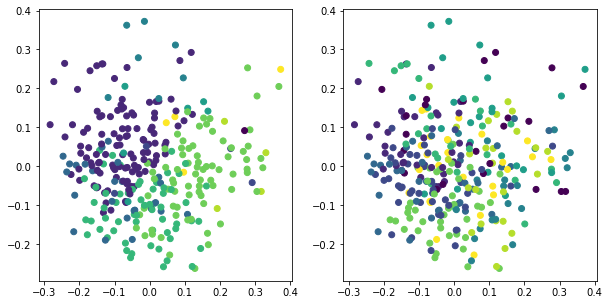

In [127]:
# kmeans = KMeans(10)
# cluster_x = kmeans.fit_predict(vectors)

from sklearn.decomposition import PCA
pca = PCA(2)
pca_x = pca.fit_transform(vectors.todense())

fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].scatter(pca_x.T[0], pca_x.T[1], c=cluster_x)
ax[1].scatter(pca_x.T[0], pca_x.T[1], c=cluster2_x)